In [74]:
%matplotlib inline

import geopandas as gpd
import pandas as pd
import cartopy.crs as ccrs
from lib.funcs import *
from lib.mapping import *

In [75]:
recorte_maior = gpd.read_file('./data/BASES/limite_recorte/limite_recorte_maior.shp')
recorte_menor = gpd.read_file('./data/BASES/limite_recorte/limite_recorte_menor.shp')
limite_mun = gpd.read_file('./data/BASES/limite_municipio/limite_municipio.shp')
lotes_empreendimentos = gpd.read_file('./data/BASES/empreendimento/empreendimento.shp')
populacao_bairros = gpd.read_file('./data/POPULACAO/bairros.shp')
populacao_setores = gpd.read_file('./data/POPULACAO/setores_recorte.shp')
limite_mun = gpd.read_file("./data/BASES/limite_municipio/limite_municipio.shp")
bairros_recorte_menor = gpd.read_file("./data/BASES/bairros/bairros_recorte_maior.shp")
bairros_recorte_maior = gpd.read_file("./data/BASES/bairros/bairros_recorte_maior.shp")

lotes_empreendimentos = lotes_empreendimentos.to_crs(epsg=3857)
bairros_recorte_maior = bairros_recorte_maior.to_crs(epsg=3857)
bairros_recorte_menor = bairros_recorte_menor.to_crs(epsg=3857)

In [76]:
bairros_recorte_maior.merge(populacao_bairros, on='NM_BAIRRO', suffixes=('_y', ''))
#bairros_recorte_maior.drop(bairros_recorte_maior.filter(regex='_y$').columns.tolist(),axis=1, inplace=True)

,NM_BAIRRO,CD_GEOCODI,coordsX,coordsY,geometry_y,MORADORES,area,densidade,geometry
0,Torre,2507507050000342507507050000352507507050000362...,-3.880777e+06,-795352.059864,"POLYGON ((-3881516.472 -795631.453, -3881565.7...",15193.0,219.546262,69.201816,"POLYGON ((-3880064.625 -795677.972, -3880027.9..."
1,Expedicionários,2507507050001582507507050001592507507050001602...,-3.879866e+06,-795091.044566,"POLYGON ((-3879845.918 -795547.234, -3879868.7...",3625.0,41.387923,87.585937,"POLYGON ((-3879845.927 -795547.226, -3879868.7..."
2,Tambauzinho,2507507050000492507507050003162507507050003172...,-3.879152e+06,-795068.346568,"POLYGON ((-3878930.143 -794601.002, -3878930.1...",4932.0,102.184745,48.265522,"MULTIPOLYGON (((-3878929.754 -794965.371, -387..."
3,Miramar,2507507050004982507507050004992507507050005002...,-3.877883e+06,-794813.479944,"POLYGON ((-3878495.257 -794755.917, -3878495.2...",9500.0,135.573160,70.072867,"POLYGON ((-3878490.080 -795268.717, -3878490.0..."
4,Pedro Gondim,2507507050003142507507050003152507507050006252...,-3.879046e+06,-794063.315146,"POLYGON ((-3879121.884 -793567.944, -3879051.7...",3360.0,78.944794,42.561388,"POLYGON ((-3879121.884 -793567.957, -3879051.7..."
5,Estados,2507507050001532507507050001542507507050001552...,-3.880179e+06,-794014.863239,"POLYGON ((-3879615.945 -793572.586, -3879435.9...",7458.0,186.984190,39.885725,"POLYGON ((-3879615.957 -793572.598, -3879435.9..."


In [78]:
#bairros_recorte_maior = gpd.GeoDataFrame(bairros_recorte_maior.merge(populacao_bairros, on='NM_BAIRRO', how='left'))


In [79]:
bairros_recorte_maior

,NM_BAIRRO,CD_GEOCODI,coordsX,coordsY,geometry
0,Torre,2507507050000342507507050000352507507050000362...,-3.880777e+06,-795352.059864,"POLYGON ((-3881516.472 -795631.453, -3881565.7..."
1,Expedicionários,2507507050001582507507050001592507507050001602...,-3.879866e+06,-795091.044566,"POLYGON ((-3879845.918 -795547.234, -3879868.7..."
2,Tambauzinho,2507507050000492507507050003162507507050003172...,-3.879152e+06,-795068.346568,"POLYGON ((-3878930.143 -794601.002, -3878930.1..."
3,Miramar,2507507050004982507507050004992507507050005002...,-3.877883e+06,-794813.479944,"POLYGON ((-3878495.257 -794755.917, -3878495.2..."
4,Pedro Gondim,2507507050003142507507050003152507507050006252...,-3.879046e+06,-794063.315146,"POLYGON ((-3879121.884 -793567.944, -3879051.7..."
5,Estados,2507507050001532507507050001542507507050001552...,-3.880179e+06,-794014.863239,"POLYGON ((-3879615.945 -793572.586, -3879435.9..."


In [80]:
lotes_empreendimentos = lotes_empreendimentos.reindex([1, 0, 2])
lotes_empreendimentos['Name'] = lotes_empreendimentos.index+1
lotes_empreendimentos['coords'] = lotes_empreendimentos['geometry'].apply(lambda x: x.centroid.coords[:])
lotes_empreendimentos['coords'] = [coords[0] for coords in lotes_empreendimentos['coords']]

/home/fc-anjos/.local/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:761: UserWarning: Approximating coordinate system <cartopy._crs.Geodetic object at 0x7f65566114a0> with the PlateCarree projection.
  warnings.warn('Approximating coordinate system {!r} with the '


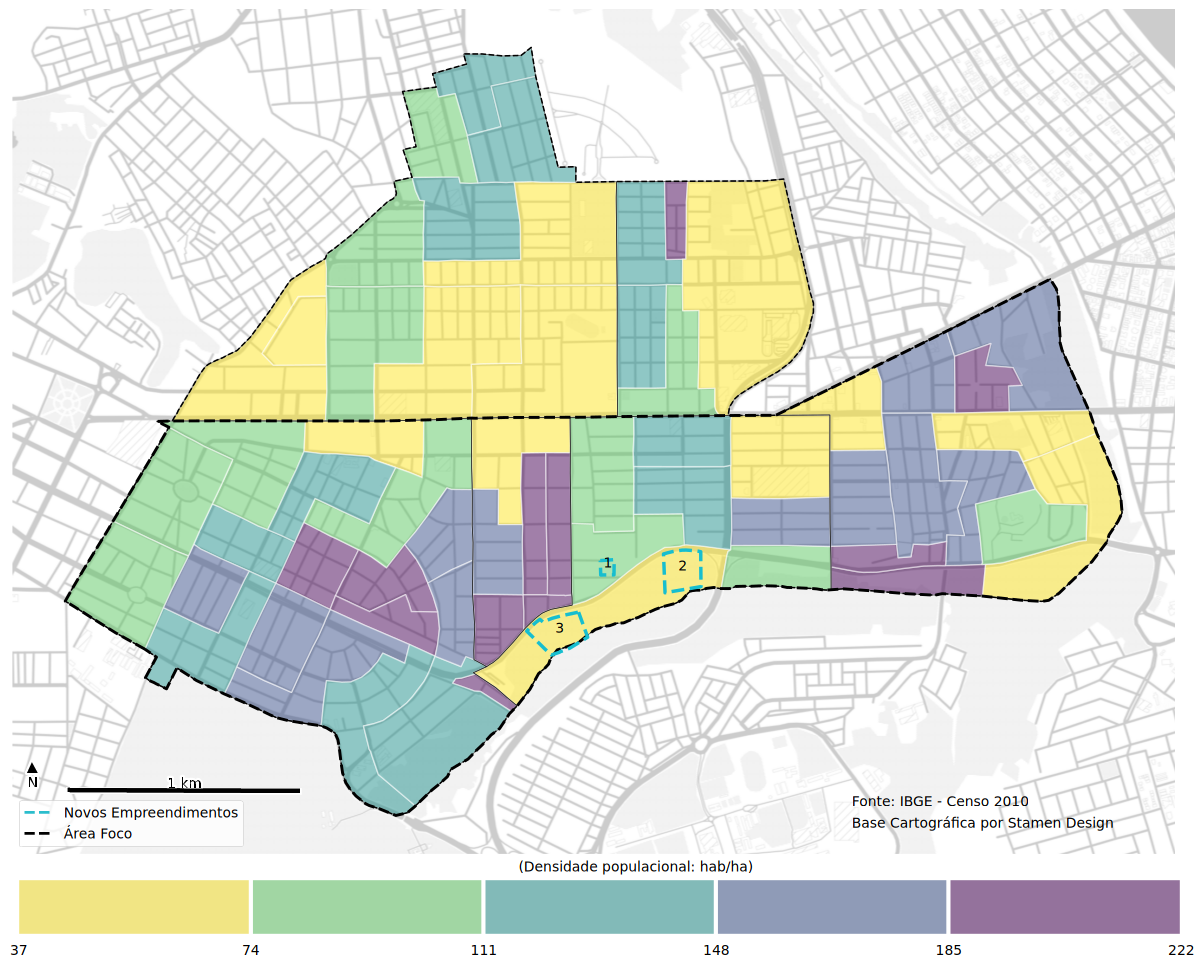

In [81]:
borders = [recorte_maior, recorte_menor]
plot_categorical(populacao_setores, 
                 'densidade',
                 5,
                 0.5,
                 [recorte_maior, recorte_menor], 
                 lotes_empreendimentos,
                 bairros_recorte_maior,
                 .83,
                 .79,
                 'densidade_populacional_recorte', 
                 (600, 95), 
                 (600, 80), 
                 (360, 48),
                 16, 
                 '(Densidade populacional: hab/ha)',
                 legend_y = 0.07,
                 scale_extension=1,
                 factor_left=1,
                 factor_right=1,
                 factor_bottom=1,
                 factor_top=1,
                 annotate_bairros=False)

KeyError: 'MORADORES'

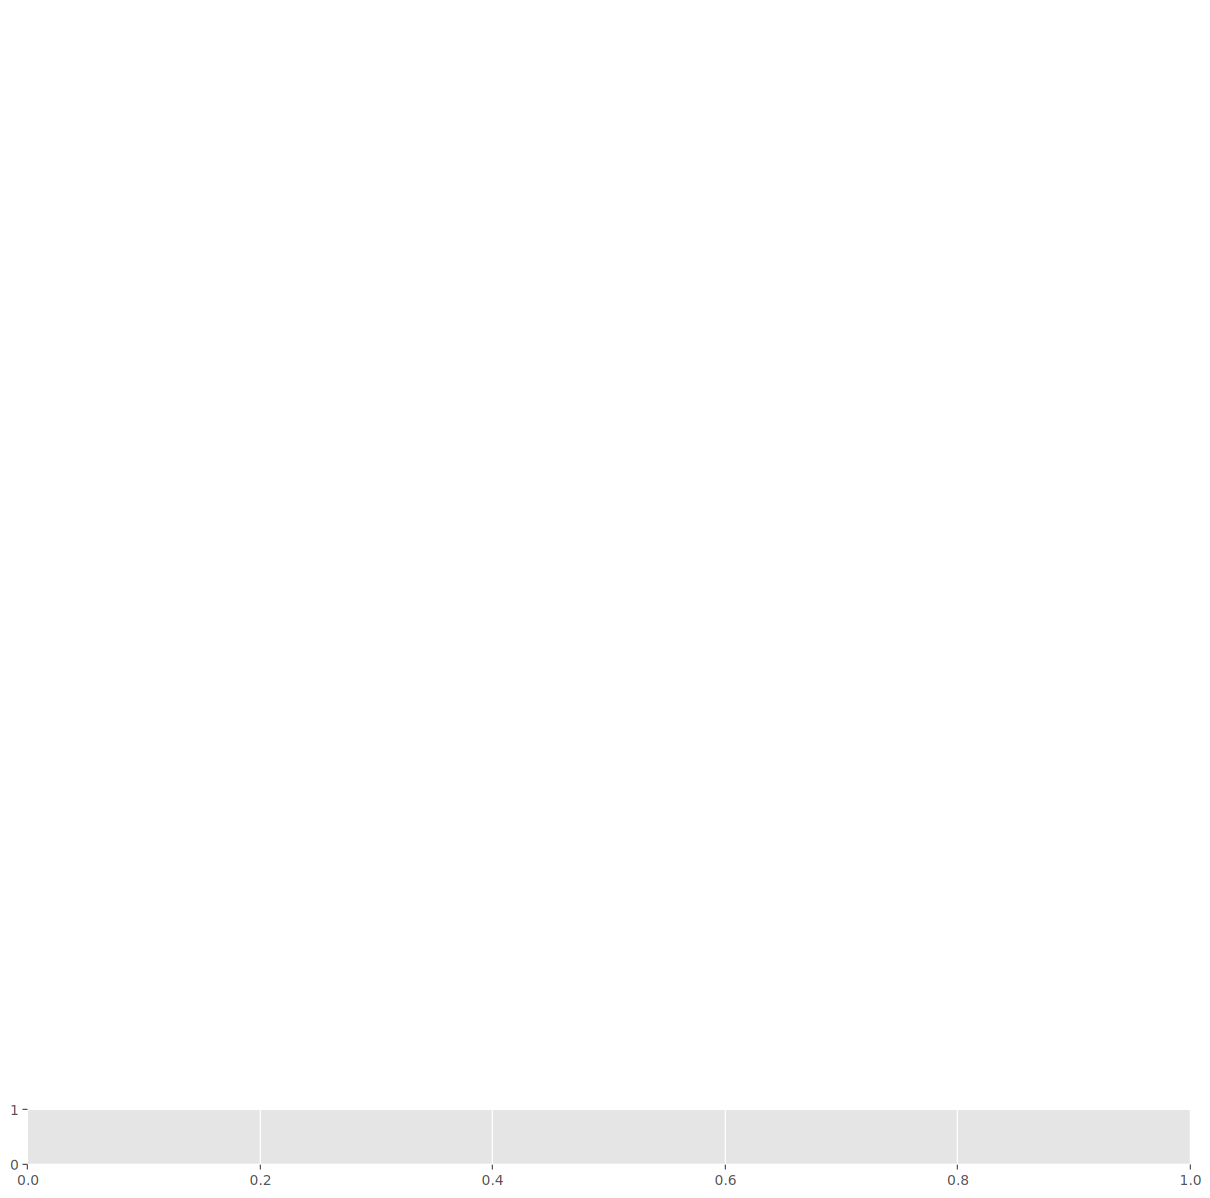

In [83]:
plot_categorical(bairros_recorte_maior, 
                 'MORADORES',
                 5,
                 0.5,
                 [recorte_maior, recorte_menor],
                 lotes_empreendimentos,
                 bairros_recorte_maior,
                 .83,
                 .79,
                 'populacao_recorte', 
                 (600, 95), 
                 (600, 80), 
                 (360, 48),
                 16, 
                 'População (hab)',
                 legend_y = 0.07,
                 scale_extension=1,
                 factor_left=1,
                 factor_right=1,
                 factor_bottom=1,
                 factor_top=1)

In [6]:
bairros_recorte_maior

,NM_BAIRRO,CD_GEOCODI,coordsX,coordsY,geometry
0,Torre,2507507050000342507507050000352507507050000362...,-3.880777e+06,-795352.059864,"POLYGON ((-3881516.472 -795631.453, -3881565.7..."
1,Expedicionários,2507507050001582507507050001592507507050001602...,-3.879866e+06,-795091.044566,"POLYGON ((-3879845.918 -795547.234, -3879868.7..."
2,Tambauzinho,2507507050000492507507050003162507507050003172...,-3.879152e+06,-795068.346568,"POLYGON ((-3878930.143 -794601.002, -3878930.1..."
3,Miramar,2507507050004982507507050004992507507050005002...,-3.877883e+06,-794813.479944,"POLYGON ((-3878495.257 -794755.917, -3878495.2..."
4,Pedro Gondim,2507507050003142507507050003152507507050006252...,-3.879046e+06,-794063.315146,"POLYGON ((-3879121.884 -793567.944, -3879051.7..."
5,Estados,2507507050001532507507050001542507507050001552...,-3.880179e+06,-794014.863239,"POLYGON ((-3879615.945 -793572.586, -3879435.9..."


In [ ]:
plot_categorical(populacao_bairros, 
                 'densidade',
                 5,
                 0.5,
                 [limite_mun, recorte_menor], 
                 lotes_empreendimentos,
                 bairros_recorte_maior,
                 .83,
                 .82,
                 'densidade_populacional_centro', 
                 (600, 95), 
                 (600, 80), 
                 (360, 48),
                 14, 
                 '(Densidade populacional: hab/ha)', 
                 scale_extension=2,
                 legend_y = 0.03,
                 factor_left=0.5,
                 factor_right=0.7,
                 factor_bottom=0.05,
                 factor_top=0.7)

In [ ]:
plot_categorical(populacao_bairros, 
                 'MORADORES',
                 5,
                 0.5,
                 [limite_mun, recorte_menor],
                 lotes_empreendimentos,
                 bairros_recorte_menor,
                 .83,
                 .84,
                 'populacao_centro', 
                 (600, 95), 
                 (600, 80), 
                 (360, 48),
                 14, 
                 'População (hab)', 
                 scale_extension=2,
                 legend_y = 0.03,
                 factor_left=0.5,
                 factor_right=0.7,
                 factor_bottom=0.05,
                 factor_top=0.7)

In [ ]:
plot_categorical(populacao_bairros, 
                 'densidade',
                 5,
                 0.5,
                 [limite_mun, recorte_menor],
                 lotes_empreendimentos,
                 bairros_recorte_menor,
                 .83,
                 .86,
                 'densidade_populacional_cidade', 
                 (600, 65), 
                 (600, 50), 
                 (360, 48),
                 13, 
                 '(Densidade populacional: hab/ha)', 
                 scale_extension=3,
                 legend_y = 0,
                 factor_left=1.45,
                 factor_right=1.45,
                 factor_bottom=1.07,
                 factor_top=1)

In [ ]:
plot_categorical(populacao_bairros, 
                 'MORADORES',
                 5,
                 0.5,
                 [limite_mun, recorte_menor],
                 lotes_empreendimentos,
                 bairros_recorte_menor,
                 .83,
                 .87,
                 'populacao_cidade', 
                 (600, 65), 
                 (600, 50), 
                 (360, 48),
                 13, 
                 'População (hab)', 
                 scale_extension=3,
                 legend_y = 0,
                 factor_left=1.45,
                 factor_right=1.45,
                 factor_bottom=1.07,
                 factor_top=1)